# Quantum tomography

Quantum tomography is the process of reconstructing the quantum state for a source of quantum systems by measurements on the systems coming from the source.

We need to obtain the best approximation $\sigma$ of the true quantum state $\rho$ using training samples $X_{train}=\{E_i,y_i\}_{i=0}^{N}$, where $E_i$ - some projector and $y_i$ - the probability (projection of true state $\rho$ on $E_i$). 

In [1]:
import numpy as np
import simulator as sim

from scipy.linalg import sqrtm
from scipy.optimize import approx_fprime
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Data

Quantum state of <i>n</i>-qubit system can be described by $2^n \times 2^n$ density matrix.  
Let's generate random $2 \times 2$ density matrix, called ```target_state```, which represents some 1-qubit system. 

In [2]:
n_qubits = 1
dim = 2 ** n_qubits
target_state = sim.randomPureState(dim)

The following function performs ```n_projectors``` different measurements.
Due to probabilistic nature, we perform ```n_measurements``` measurements per each individual projector.
Set of projectors ```X_train``` and  corresponding probabilities that a measurement of a quantum system will yield a given result ```y_train``` are returned.

In [3]:
def generate_dataset(target_state, n_projectors, n_measurements):
    dim = target_state.shape[0]
    X_train = np.array([sim.randomPureState(dim) for _ in range(n_projectors)])
    
    y_train = []
    for projector in X_train:
        ones, zeroes = sim.measure(n_measurements, target_state, projector)
        y_train.append(ones / n_measurements)
    y_train = np.array(y_train)
        
    return X_train, y_train

In [4]:
X_train, y_train = generate_dataset(target_state, n_projectors=5, n_measurements=100)

Fidelity is used to measure how close are two quantum states, e.g. our estimated and true states.

In [5]:
def fidelity(state_1, state_2):
    state_1_sqrt = sqrtm(state_1)
    F = np.dot(np.dot(state_1_sqrt, state_2), state_1_sqrt)
    return (np.trace(sqrtm(F)) ** 2).real

SciPy works with real-valued vectors, so we need this hepler functions for forward and backward conversions.

In [6]:
def to_realvector(z):
    z = z.reshape(-1)                       # complex matrix n * n -> complex vector of length n ** 2
    return np.concatenate((z.real, z.imag)) # complex of length n ** 2 -> real vector of length 2 * (n ** 2)

def to_complexmatrix(z): 
    half = len(z)//2
    z = z[:half] + 1j * z[half:]            # real vector of length 2 * (n ** 2) -> complex of length n ** 2
    n = np.sqrt(half).astype(np.int)
    return z.reshape(n, n)                  # complex of length n ** 2 -> complex matrix n * n

### Loss function

It is proposed to minimize mean-squared-error between measurements on true state and measurements on current estimated state.
$$\min_\sigma[loss(\sigma)=\sum_i(Tr(E_i\sigma)-Tr(E_i\rho))^2=\sum_i(Tr(E_i\sigma)-y_i)^2]$$  
where $\sigma$ is density matrix, i.e. a positive semidefinite, Hermitian operator of trace 1 acting on the state space.  

In order to make this minimization unconditional, lets decompose $\sigma$ in the following way:
 
$$\sigma=\frac{M^{\dagger}M}{Tr(M^{\dagger}M)}$$

```to_density``` associates each arbitrary matrix with a density operator.

In [7]:
def to_density(M):
    state = M.T.conj().dot(M)
    norm = np.trace(state).real.sum()
    return state / norm

So the final minimization functional defined as follows:
$$\min_M\Big[loss(M)=\sum_i\Big(Tr\big(E_i\frac{M^{\dagger}M}{Tr(M^{\dagger}M)}\big)-y_i\Big)^2\Big]$$

In [8]:
def loss(M, X_train, y_train):
    pred_state = to_density(M)
    pred = np.trace(np.einsum('bij,jk->bik', X_train, pred_state), axis1=1, axis2=2).real
    return np.mean((pred - y_train) ** 2)

### Optimization

Let's start with some random estimation of our quantum system state. 

In [9]:
M = sim.randomMixedState(dim)
init_state = to_density(M)

print('init fidelity:\t', fidelity(target_state, init_state))
print('init loss:\t', loss(M, X_train, y_train))

init fidelity:	 0.5616782457741714
init loss:	 0.17174617397099792


We will use gradient descent as a minimization algorithm.  
The key idea: starting at the top of the mountain, we take our first step downhill in the direction specified by the negative gradient. Next we recalculate the negative gradient and take another step. We continue this process iteratively to a point where we can no longer move downhill localy. 

The gradient is estimated approximately by ```scipy.optimize.approx_fprime``` function.

In [10]:
max_iters = 1000
learning_rate = 5e-2
early_stopping_criteria = 1e-3
loss_history = []
fidelity_history = []

M_vec = to_realvector(M)

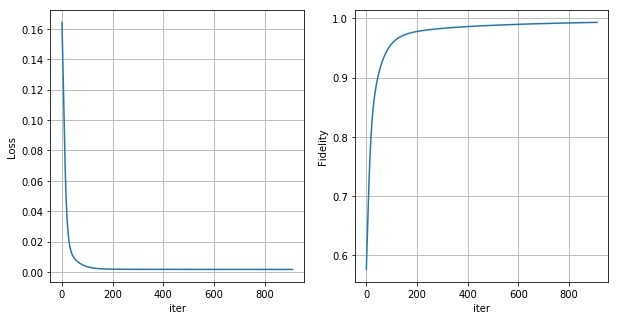

In [11]:
for step in range(max_iters):
    
    grad = approx_fprime(M_vec, lambda x: loss(to_complexmatrix(x), X_train, y_train), epsilon=1e-3)
    M_vec -= grad * learning_rate
    
    M = to_complexmatrix(M_vec)
    pred_state = to_density(M)
    loss_history.append(loss(M, X_train, y_train))
    fidelity_history.append(fidelity(target_state, pred_state))
    
    if step % 10 == 0:
        clear_output(True)
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.xlabel('iter')
        plt.ylabel('Loss')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(122)
        plt.xlabel('iter')
        plt.ylabel('Fidelity')
        plt.plot(fidelity_history)
        plt.grid()
        plt.show()
    
    if np.sqrt((grad ** 2).sum()) < early_stopping_criteria:
        break

Final evaluation

In [12]:
M = to_complexmatrix(M_vec)
pred_state = to_density(M)

print('final fidelity:\t', fidelity(target_state, pred_state))
print('final loss:\t', loss(M, X_train, y_train))

final fidelity:	 0.9931266115176592
final loss:	 0.0016719584597964798


### Qubit visualization

The Bloch sphere is a geometric representation of qubit states as points on the surface (pure states) or inside (mixed states) of a unit sphere.  
Before visualization, we need to converts density matrices to coordinates on the Bloch sphere

In [14]:
import qutip # use pip install qutip

In [15]:
def density_to_bloch(density_matrix):
    x = 2 * density_matrix[0, 1].real
    y = 2 * density_matrix[1, 0].imag
    z = (density_matrix[0, 0] - density_matrix[1, 1]).real
    return np.array([x, y, z])

<font color='blue'>Blue</font>, <font color='green'>green</font>, <font color='orange'>orange</font> vectors representing ```init_state```, ```target_state``` and ```pred_state``` respectively. As we can see from the picture, our estimated state is close enough to true quantum state.

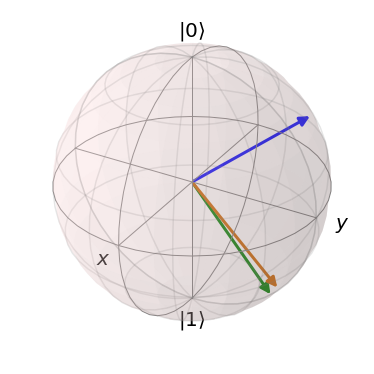

In [16]:
b = qutip.Bloch()
b.add_vectors(list(map(density_to_bloch, [target_state, pred_state, init_state])))
b.show()

### Summary

In this practical lesson we
* studied the basics of quantum tomography
* represented this task as an optimizational problem
* solved optimizational problem by Gradient Descent algorithm.
* we visualized final results on Bloch Sphere